# Preprocessing

In [2]:
import pandas as pd

test_df = pd.read_csv('result/asap_all_data.csv')
test_df.shape

(21448, 2)

In [3]:
test_df.head(2)

,essay_id,essay
0,1,"Dear local newspaper, I think effects computer..."
1,2,"Dear @CAPS1 @CAPS2, I believe that using compu..."


In [4]:
test_df['len_essay'] = test_df['essay'].apply(lambda x:len(x))
test_df = test_df[test_df['len_essay']>690].reset_index(drop=True)
print("test_df['len_essay'].max() = ", test_df['len_essay'].max())
test_df.shape

test_df['len_essay'].max() =  6098


(13747, 3)

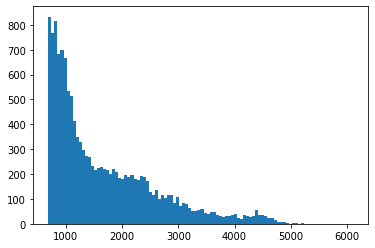

In [5]:
import matplotlib.pyplot as plt

plt.hist(test_df['len_essay'].values, bins=100);

In [6]:
orig_df = pd.read_csv('../input/feedback-prize-effectiveness/train.csv')
orig_df.head(2)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate


In [7]:
unique_ids = sorted(orig_df['essay_id'].unique())
len(unique_ids)

4191

In [8]:
from tqdm import tqdm

essays = []
for essay_id in tqdm(unique_ids):
    with open(f'../input/feedback-prize-effectiveness/train/{essay_id}.txt', 'rb') as f:
        text = f.read()
        essays.append([essay_id, text, len(text)])

100%|██████████| 4191/4191 [00:04<00:00, 920.33it/s] 


In [9]:
orig_df = pd.DataFrame(essays, columns=['essay_id', 'essay', 'len_essay'])

In [10]:
orig_df['len_essay'].min()

691

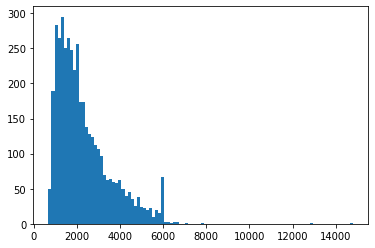

In [11]:
plt.hist(orig_df['len_essay'].values, bins=100);

# Span Detector

In [12]:
test_df.shape

(13747, 3)

In [13]:
VERSION = '../code/kaggle-feedback-prize-effectiveness/27_ASAP/27_vl_01'

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import sys
sys.path.append(VERSION)

In [14]:
from models import DatasetTest, TestCollator, TextSpanDetector
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

import transformers
transformers.logging.set_verbosity_error()

class args:
    model = 'microsoft/deberta-large'
    num_classes = 7

tokenizer = AutoTokenizer.from_pretrained(args.model)

ds = DatasetTest(test_df, tokenizer)
dl = DataLoader(
    ds,
    batch_size=1,
    shuffle=False,
    collate_fn=TestCollator(tokenizer),
    num_workers=4, 
    pin_memory=True,
    drop_last=False,
)

2022-08-07 05:51:55.550219: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Loaded 13747 samples.


In [15]:
model = TextSpanDetector(
    args.model,
    tokenizer,
    num_classes=args.num_classes,
)

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

In [16]:
import torch
pretrain_path = '../input/tascj/result/deberta_large_fold0.pth'

model.load_state_dict(torch.load(pretrain_path))

<All keys matched successfully>

# Inference

In [17]:
from tqdm import tqdm

pred_df = []
for data in tqdm(dl):
    tmp_df = model.cuda().test_step(data, test_score_thr=0.5)
    pred_df.append(tmp_df)
    
pred_df = pd.concat(pred_df, axis=0).reset_index(drop=True)
print('pred_df.shape = ', pred_df.shape)
pred_df.to_csv('pred_df.csv', index=False)

100%|██████████| 13747/13747 [27:30<00:00,  8.33it/s]


pred_df.shape =  (84519, 3)


In [18]:
pred_df.head()

,essay_id,class,predictionstring
0,1,Claim,24 25 26 27 28 29 30 31
1,1,Position,3 4 5 6 7 8 9 10 11 12 13 14 15
2,1,Claim,31 32 33 34 35 36
3,1,Claim,15 16 17 18 19 20 21 22 23 24
4,1,Concluding Statement,285 286 287 288 289 290 291 292 293 294 295 29...
